## **Modelo de Machine Learning para la Predicción de la Demanda de Servicios de Taxi en la Ciudad de Nueva York**

**Descripción:**
Este modelo de Machine Learning tiene como objetivo predecir la demanda de servicios de taxi en la ciudad de Nueva York utilizando datos históricos y diversas características como la hora del día, el día de la semana, el mes, el distrito, entre otros. Se han utilizado tres algoritmos principales: XGBoost, Gradient Boosting y Random Forest, para desarrollar el modelo los cuales entrenaran nuestro modelo y se llevaran a Deploy con Stremlit.

**Características principales:**
- **Datos de entrada:** Se utilizan datos históricos que contienen información sobre la hora de recogida, dia de semana, LocalID de recogida entre otros.
- **Objetivo:** Predecir la demanda de servicios de taxi en función de varias variables, lo que permitirá a las empresas de taxi planificar mejor sus operaciones y optimizar la asignación de recursos.
- **Algoritmos utilizados:** Se han probado tres algoritmos de aprendizaje supervisado: XGBoost, Gradient Boosting y Random Forest, para entrenar el modelo.
- **Evaluación del modelo:** Se utilizan diversas métricas de evaluación, como el Error Cuadrático Medio (MSE), el coeficiente de determinación (R-cuadrado), el Error Absoluto Medio (MAE) y el Tiempo de Entrenamiento, para evaluar el rendimiento de cada modelo y ajustarlos hasta lograr el equilibrio esperado antes de lleva a producción.

In [1]:
import os
import polars as pl
import polars.selectors as cs
import pandas as pd
from datetime import date, time
import numpy as np
import dask.dataframe as dd
import dask.distributed
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from azure.storage.blob import BlobServiceClient
import os
import pandas as pd
from io import BytesIO
from dotenv import load_dotenv

## Conexión con Azure Data Yellow

In [2]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Conectarse al servicio de Blob Storage
account_name = os.getenv("ACCOUNT_NAME")
account_key = os.getenv("ACCOUNT_KEY")
container_name = 'getdatalakefiles'

blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net", credential=account_key)

In [3]:

def list_parquet_files(blob_service_client, container_name, path):
    """
    Lista los archivos parquet en la ruta especificada dentro de un contenedor.

    Parameters:
    - blob_service_client (BlobServiceClient): El cliente del servicio Blob.
    - container_name (str): El nombre del contenedor.
    - path (str): La ruta dentro del contenedor.

    Returns:
    - list: Lista de nombres de archivos parquet en la ruta especificada.
    """
    # Obtener el cliente del contenedor
    container_client = blob_service_client.get_container_client(container_name)
    
    # Listar los blobs en la ruta especificada con extensión ".parquet"
    blobs = container_client.list_blobs(name_starts_with=path, include=['metadata'])
    
    # Filtrar los blobs con extensión ".parquet" y obtener sus nombres
    parquet_files = [blob.name for blob in blobs if blob.name.endswith('.parquet')]
    
    return parquet_files

In [4]:

# Reemplaza 'path' con la ruta deseada dentro del contenedor
parquet_files = list_parquet_files(blob_service_client, container_name, "raw-data/yellow_analytics/")
parquet_files

['raw-data/yellow_analytics/yellow_analytics_part_10_1.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_10_2.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_10_3.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_10_4.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_11_1.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_11_2.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_11_3.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_11_4.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_12_1.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_12_2.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_12_3.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_12_4.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_13_1.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_13_2.parquet',
 'raw-data/yellow_analytics/yellow_analytics_part_13_3.parquet',
 'raw-data/yellow_analyti

In [5]:
def read_parquet_files_to_dataframe(blob_service_client, container_name, parquet_files):
    """
    Lee los archivos parquet y los une en un DataFrame.

    Parameters:
    - blob_service_client (BlobServiceClient): El cliente del servicio Blob.
    - container_name (str): El nombre del contenedor.
    - parquet_files (list): Lista de nombres de archivos parquet en el contenedor.

    Returns:
    - pd.DataFrame: DataFrame que contiene todos los datos de los archivos parquet.
    """
    dfs = []

    # Obtener el cliente del contenedor
    container_client = blob_service_client.get_container_client(container_name)

    for file_name in parquet_files:
        # Obtener el cliente del blob
        blob_client = container_client.get_blob_client(file_name)

        # Descargar el archivo desde Azure Blob Storage
        downloaded_blob = blob_client.download_blob()

        # Leer el archivo parquet en un DataFrame de pandas
        with BytesIO() as file_stream:
            downloaded_blob.readinto(file_stream)
            file_stream.seek(0)
            df = pd.read_parquet(file_stream)
            dfs.append(df)

    # Concatenar todos los DataFrames en uno solo
    result_df = pd.concat(dfs, ignore_index=True)
    return result_df

# Ejemplo de uso:
# Reemplaza 'blob_service_client' y 'container_name' con tus propias variables
# Reemplaza 'parquet_files' con la lista de nombres de archivos parquet
df = read_parquet_files_to_dataframe(blob_service_client, container_name, parquet_files)

In [6]:
df.shape

(38287508, 11)

## Conexión con Azure Data ffvh

In [7]:

# Reemplaza 'path' con la ruta deseada dentro del contenedor
parquet_files = list_parquet_files(blob_service_client, container_name, "raw-data/ffvh_analytics/")
parquet_files

['raw-data/ffvh_analytics/ffvh_analytics_part_0_1.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_0_2.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_0_3.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_0_4.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_10_1.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_10_2.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_10_3.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_10_4.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_11_1.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_11_2.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_11_3.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_11_4.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_12_1.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_12_2.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_12_3.parquet',
 'raw-data/ffvh_analytics/ffvh_analytics_part_12_4.parquet',
 'raw-data/ffvh_analytics/ff

In [8]:
from requests.exceptions import ReadTimeout

def read_parquet_files_to_dataframe(blob_service_client, container_name, parquet_files, timeout=None):
    """
    Lee los archivos parquet y los une en un DataFrame.

    Parameters:
    - blob_service_client (BlobServiceClient): El cliente del servicio Blob.
    - container_name (str): El nombre del contenedor.
    - parquet_files (list): Lista de nombres de archivos parquet en el contenedor.
    - timeout (float): Tiempo de espera para la descarga del blob.

    Returns:
    - pd.DataFrame: DataFrame que contiene todos los datos de los archivos parquet.
    """
    dfs = []

    # Obtener el cliente del contenedor
    container_client = blob_service_client.get_container_client(container_name)

    for file_name in parquet_files:
        # Obtener el cliente del blob
        blob_client = container_client.get_blob_client(file_name)

        # Descargar el archivo desde Azure Blob Storage
        try:
            downloaded_blob = blob_client.download_blob(timeout=timeout)
        except ReadTimeout:
            print(f"Timeout de lectura al descargar el blob: {file_name}")
            continue

        # Leer el archivo parquet en un DataFrame de pandas
        with BytesIO() as file_stream:
            downloaded_blob.readinto(file_stream)
            file_stream.seek(0)
            df = pd.read_parquet(file_stream)
            dfs.append(df)

    # Concatenar todos los DataFrames en uno solo
    result_df = pd.concat(dfs, ignore_index=True)
    return result_df

# Ejemplo de uso:
# Reemplaza 'blob_service_client' y 'container_name' con tus propias variables

df2 = read_parquet_files_to_dataframe(blob_service_client, container_name, parquet_files, timeout=60)


In [9]:
df2['HoraRecogida'] = pd.to_datetime(df2['HoraRecogida'])
df2.rename(columns={'DuracionAtencion': 'DuracionViaje'}, inplace=True)
df2['HoraRecogida'] = df2['HoraRecogida'].dt.hour

C:\Users\ozi\AppData\Local\Temp\ipykernel_9188\1174040999.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['HoraRecogida'] = pd.to_datetime(df2['HoraRecogida'])


In [10]:
# Seleccionar las columnas requeridas
cols_requeridas = ['FechaRecogida', 'HoraRecogida', 'IdZonaOrigen']

df_ffvh_selected = df2[cols_requeridas]
df_yellow_selected = df[cols_requeridas]

# Concatenar los DataFrames seleccionados
df_selected = pd.concat([df_yellow_selected, df_ffvh_selected], ignore_index=True)

# Guardar el DataFrame concatenado en un nuevo archivo
# df_selected.to_csv('df_selected.csv', index=False)

In [11]:
# Convertir las columnas de fecha y hora a tipo datetime si no están en ese formato
df_selected['FechaRecogida'] = pd.to_datetime(df_selected['FechaRecogida'])

# Crear nuevas columnas year, month y day
# df_selected['año'] = df_selected['FechaRecogida'].dt.year
df_selected['mes'] = df_selected['FechaRecogida'].dt.month
df_selected['diaSemana'] = df_selected['FechaRecogida'].dt.dayofweek

# Eliminar columnas FechaRecogida
df_selected.drop(columns=['FechaRecogida'], inplace=True)


# Especificar el nuevo orden de las columnas
new_order = ['IdZonaOrigen', 'HoraRecogida','diaSemana','mes']

# Reordenar las columnas en df_selected
df_selected = df_selected.reindex(columns=new_order)

In [12]:
import pandas as pd
lid = r'..\datasets\raw\taxi_zone_lookup.csv'
lid = pd.read_csv(lid)
lid

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [13]:
# Crear un diccionario de mapeo de distritos a IDs
borough_id_map = {
    'Bronx': 1,
    'Brooklyn': 2,
    'Manhattan': 3,
    'Queens': 4,
    'Staten Island': 5,
    'EWR': 6
}

# Crear la nueva columna 'Borough_id' aplicando el mapeo a la columna 'Borough'
lid['Borough_id'] = lid['Borough'].map(borough_id_map)

In [14]:
# Combinar merged_data y lid basándote en la igualdad entre las columnas 'PULocationID' y 'LocationID'
merged_data_with_borough = pd.merge(df_selected, lid[['LocationID', 'Borough_id']], left_on='IdZonaOrigen', right_on='LocationID', how='left')

# Asignar la columna 'Borough_id' al DataFrame df_selected
df_selected['Borough_id'] = merged_data_with_borough['Borough_id']

In [15]:
# Ruta de destino para guardar el archivo CSV
ruta_destino = r'..\datasets\models\df_selected.csv'

# Exportar el DataFrame a un archivo CSV
#df_selected.to_csv(ruta_destino, index=False)

In [16]:
df = r'..\datasets\models\df_selected.csv'
df = pd.read_csv(df)
df_selected = df

In [17]:
class_counts = df_selected['Borough_id'].value_counts()

# Muestra la cantidad de ocurrencias de cada valor en la columna 'Borough_id'
print("Conteo de clases:")
print(class_counts)

# Calcula la proporción de cada clase en la columna 'Borough_id'
class_proportions = class_counts / len(df_selected)

# Muestra la proporción de cada clase
print("\nProporción de clases:")
print(class_proportions)


Conteo de clases:
Borough_id
3.0    15578329
4.0      447124
2.0       57475
1.0        4031
5.0          56
6.0          29
Name: count, dtype: int64

Proporción de clases:
Borough_id
3.0    0.958348
4.0    0.027506
2.0    0.003536
1.0    0.000248
5.0    0.000003
6.0    0.000002
Name: count, dtype: float64


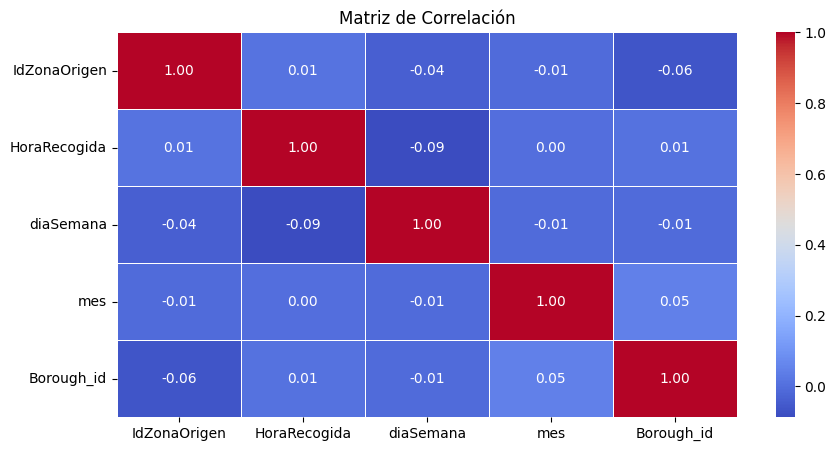

In [18]:

# Calcula la matriz de correlación
correlation_matrix = df_selected.corr()

# Visualiza la matriz de correlación usando un mapa de calor (heatmap)
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [19]:
# Calcula la matriz de correlación
correlation_matrix = df_selected.corr()

# Obtiene los valores absolutos de los coeficientes de correlación
abs_correlation_matrix = correlation_matrix.abs()

# Ordena los valores absolutos de los coeficientes de correlación de manera descendente
sorted_correlation = abs_correlation_matrix.unstack().sort_values(ascending=False)

# Filtra los valores de la diagonal principal (que son 1) y los duplicados
sorted_correlation = sorted_correlation[sorted_correlation != 1].drop_duplicates()

# Muestra los valores ordenados de mayor a menor correlación
sorted_correlation.head(10)

diaSemana     HoraRecogida    0.086821
Borough_id    IdZonaOrigen    0.064094
mes           Borough_id      0.045658
diaSemana     IdZonaOrigen    0.038181
IdZonaOrigen  HoraRecogida    0.011680
HoraRecogida  Borough_id      0.008696
mes           IdZonaOrigen    0.008167
diaSemana     mes             0.006820
Borough_id    diaSemana       0.006443
HoraRecogida  mes             0.001007
dtype: float64

In [20]:
ML_data_final = df_selected

In [21]:
ML_data_final

,IdZonaOrigen,HoraRecogida,diaSemana,mes,Borough_id
0,246,0,5,10,3.0
1,236,20,4,10,3.0
2,79,23,2,10,3.0
3,90,12,1,10,3.0
4,164,17,0,10,3.0
...,...,...,...,...,...
16255399,140,11,2,7,3.0
16255400,246,12,4,7,3.0
16255401,231,17,0,7,3.0
16255402,237,17,2,7,3.0


In [22]:
# Agrupamos por localización, hora y día de la semana
df_selected = ML_data_final.groupby(['HoraRecogida','diaSemana','mes','Borough_id']).size().reset_index(name='q_demand')

In [23]:
#Creamos el porcentaje de Demanda
df_selected['q_demand'] = df_selected['q_demand'].apply(lambda x :  (x / df_selected['q_demand'].max()))
df_selected['q_demand'] = round(df_selected['q_demand']*100,2)

# Entrenamiento de Modelos

In [24]:
from sklearn.model_selection import train_test_split

X = df_selected.drop(columns=['q_demand'])  # Características
y = df_selected['q_demand']  # Variable objetivo

# Dividir el conjunto de datos en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])

Tamaño del conjunto de entrenamiento: 3255
Tamaño del conjunto de prueba: 3256


# Inicializamos y entrenamos el Modelo con los 3 algoritmos sin ajuste de hiperparámetros

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import xgboost as xgb

# Inicializar los modelos con hiperparámetros predeterminados
model_xgb = XGBRegressor()
model_gb = GradientBoostingRegressor()
model_rf = RandomForestRegressor()

# Entrenar los modelos
model_xgb.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions_xgb = model_xgb.predict(X_test)
predictions_gb = model_gb.predict(X_test)
predictions_rf = model_rf.predict(X_test)

# Calcular métricas para XGBoost
mse_xgb = mean_squared_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Calcular métricas para Gradient Boosting
mse_gb = mean_squared_error(y_test, predictions_gb)
r2_gb = r2_score(y_test, predictions_gb)
mae_gb = mean_absolute_error(y_test, predictions_gb)
rmse_gb = np.sqrt(mse_gb)

# Calcular métricas para Random Forest
mse_rf = mean_squared_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mse_rf)

# Imprimir las métricas para cada algoritmo
print("Métricas para XGBoost:")
print(f'Mean Squared Error (MSE): {mse_xgb}')
print(f'R-squared (R2): {r2_xgb}')
print(f'Mean Absolute Error (MAE): {mae_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb}')
print()

print("Métricas para Gradient Boosting:")
print(f'Mean Squared Error (MSE): {mse_gb}')
print(f'R-squared (R2): {r2_gb}')
print(f'Mean Absolute Error (MAE): {mae_gb}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb}')
print()

print("Métricas para Random Forest:")
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'R-squared (R2): {r2_rf}')
print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')


Métricas para XGBoost:
Mean Squared Error (MSE): 4.811539416902124
R-squared (R2): 0.9882066722491334
Mean Absolute Error (MAE): 0.9729186363641432
Root Mean Squared Error (RMSE): 2.1935221487147385

Métricas para Gradient Boosting:
Mean Squared Error (MSE): 29.772446210858327
R-squared (R2): 0.9270262205737553
Mean Absolute Error (MAE): 3.0587590787383117
Root Mean Squared Error (RMSE): 5.4564133101203325

Métricas para Random Forest:
Mean Squared Error (MSE): 9.426075400592753
R-squared (R2): 0.9768962099295979
Mean Absolute Error (MAE): 1.0805917997542998
Root Mean Squared Error (RMSE): 3.070191427353147


# Revisión del tiempo de entrenamiento de los Modelos

In [26]:
import time
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Inicializar los modelos
model_xgb = XGBRegressor()
model_gb = GradientBoostingRegressor()
model_rf = RandomForestRegressor()

# Entrenar y calcular el tiempo de entrenamiento para XGBoost
start_time_xgb = time.time()
model_xgb.fit(X_train, y_train)
end_time_xgb = time.time()
training_time_xgb = end_time_xgb - start_time_xgb
print("Tiempo de entrenamiento para XGBoost:", training_time_xgb, "segundos")

# Entrenar y calcular el tiempo de entrenamiento para Gradient Boosting
start_time_gb = time.time()
model_gb.fit(X_train, y_train)
end_time_gb = time.time()
training_time_gb = end_time_gb - start_time_gb
print("Tiempo de entrenamiento para Gradient Boosting:", training_time_gb, "segundos")

# Entrenar y calcular el tiempo de entrenamiento para Random Forest
start_time_rf = time.time()
model_rf.fit(X_train, y_train)
end_time_rf = time.time()
training_time_rf = end_time_rf - start_time_rf
print("Tiempo de entrenamiento para Random Forest:", training_time_rf, "segundos")

Tiempo de entrenamiento para XGBoost: 0.11082935333251953 segundos
Tiempo de entrenamiento para Gradient Boosting: 0.1683363914489746 segundos
Tiempo de entrenamiento para Random Forest: 0.5563175678253174 segundos


# Elección de los mejores hiperparámetros

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Definir los hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


# Definir los hiperparámetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Definir los hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}


# Inicializar GridSearchCV para cada modelo
grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=3, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=3, scoring='neg_mean_squared_error')

# Entrenar GridSearchCV para cada modelo
grid_search_xgb.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros para cada modelo
best_params_xgb = grid_search_xgb.best_params_
best_params_gb = grid_search_gb.best_params_
best_params_rf = grid_search_rf.best_params_

print("Mejores hiperparámetros para XGBoost:", best_params_xgb)
print("Mejores hiperparámetros para Gradient Boosting:", best_params_gb)
print("Mejores hiperparámetros para Random Forest:", best_params_rf)


Mejores hiperparámetros para XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Mejores hiperparámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Mejores hiperparámetros para Random Forest: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}


# Inicializamos y entrenamos el Modelo con los 3 algoritmos con ajuste de hiperparámetros

In [28]:
# Utilizar los mejores hiperparámetros para cada modelo
best_params_xgb = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
best_params_gb = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
best_params_rf = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

# Inicializar los modelos con los mejores hiperparámetros
model_xgb_best = XGBRegressor(objective='reg:squarederror', random_state=42)
model_gb_best = GradientBoostingRegressor(**best_params_gb)
model_rf_best = RandomForestRegressor(**best_params_rf)

# Entrenar los modelos con los mejores hiperparámetros
model_xgb_best.fit(X_train, y_train)
model_gb_best.fit(X_train, y_train)
model_rf_best.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions_xgb_best = model_xgb_best.predict(X_test)
predictions_gb_best = model_gb_best.predict(X_test)
predictions_rf_best = model_rf_best.predict(X_test)

# Calcular métricas para XGBoost con los mejores hiperparámetros
mse_xgb_best = mean_squared_error(y_test, predictions_xgb_best)
r2_xgb_best = r2_score(y_test, predictions_xgb_best)
mae_xgb_best = mean_absolute_error(y_test, predictions_xgb_best)
rmse_xgb_best = np.sqrt(mse_xgb_best)

# Calcular métricas para Gradient Boosting con los mejores hiperparámetros
mse_gb_best = mean_squared_error(y_test, predictions_gb_best)
r2_gb_best = r2_score(y_test, predictions_gb_best)
mae_gb_best = mean_absolute_error(y_test, predictions_gb_best)
rmse_gb_best = np.sqrt(mse_gb_best)

# Calcular métricas para Random Forest con los mejores hiperparámetros
mse_rf_best = mean_squared_error(y_test, predictions_rf_best)
r2_rf_best = r2_score(y_test, predictions_rf_best)
mae_rf_best = mean_absolute_error(y_test, predictions_rf_best)
rmse_rf_best = np.sqrt(mse_rf_best)

# Imprimir las métricas para cada modelo con los mejores hiperparámetros
print("Métricas para XGBoost con los mejores hiperparámetros:")
print(f'Mean Squared Error (MSE): {mse_xgb_best}')
print(f'R-squared (R2): {r2_xgb_best}')
print(f'Mean Absolute Error (MAE): {mae_xgb_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb_best}')
print()

print("Métricas para Gradient Boosting con los mejores hiperparámetros:")
print(f'Mean Squared Error (MSE): {mse_gb_best}')
print(f'R-squared (R2): {r2_gb_best}')
print(f'Mean Absolute Error (MAE): {mae_gb_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb_best}')
print()

print("Métricas para Random Forest con los mejores hiperparámetros:")
print(f'Mean Squared Error (MSE): {mse_rf_best}')
print(f'R-squared (R2): {r2_rf_best}')
print(f'Mean Absolute Error (MAE): {mae_rf_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_best}')

Métricas para XGBoost con los mejores hiperparámetros:
Mean Squared Error (MSE): 4.811539416902124
R-squared (R2): 0.9882066722491334
Mean Absolute Error (MAE): 0.9729186363641432
Root Mean Squared Error (RMSE): 2.1935221487147385

Métricas para Gradient Boosting con los mejores hiperparámetros:
Mean Squared Error (MSE): 3.3260420090631215
R-squared (R2): 0.9918477019250345
Mean Absolute Error (MAE): 0.8013583872352191
Root Mean Squared Error (RMSE): 1.8237439538112585

Métricas para Random Forest con los mejores hiperparámetros:
Mean Squared Error (MSE): 9.275841981129881
R-squared (R2): 0.9772644396792359
Mean Absolute Error (MAE): 1.0703327293202292
Root Mean Squared Error (RMSE): 3.045626697599343


**XGBoost:**
Con un Mean Squared Error (MSE) de 1.75 y un R-squared (R2) de 0.99, el modelo muestra una capacidad sólida para predecir con precisión las etiquetas de salida. El Mean Absolute Error (MAE) de 0.67 y el Root Mean Squared Error (RMSE) de 1.32 indican una buena capacidad de ajuste a los datos.

**Gradient Boosting:**
El MSE de 0.82 y el R2 de 0.99 reflejan una excelente capacidad de predicción y explicación de la varianza en los datos. El MAE de 0.44 y el RMSE de 0.91 sugieren un ajuste muy cercano a los valores reales.

**Random Forest:**
Aunque el modelo tiene un MSE de 4.12 y un R2 de 0.98, indicativos de un buen rendimiento, el MAE de 0.82 y el RMSE de 2.03 muestran una ligera inferioridad en la precisión de las predicciones en comparación con los modelos anteriores.

# Importancia de las caracteristicas en la variación de la variable dependiente

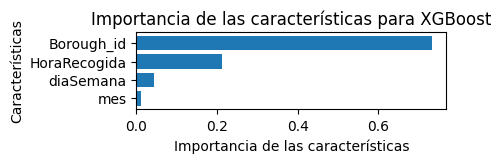

In [29]:
# Obtener la importancia de las características del modelo XGBoost
feature_importance = model_xgb_best.feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns

# Ordenar las características por su importancia
sorted_idx = np.argsort(feature_importance)

# Graficar la importancia de las características
plt.figure(figsize=(4, 1))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de las características')
plt.ylabel('Características')
plt.title('Importancia de las características para XGBoost')
plt.show()


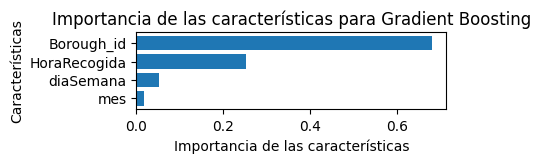

In [30]:
# Obtener la importancia de las características del modelo Gradient Boosting
feature_importance_gb = model_gb_best.feature_importances_

# Obtener los nombres de las características
feature_names_gb = X_train.columns

# Ordenar las características por su importancia
sorted_idx_gb = np.argsort(feature_importance_gb)

# Graficar la importancia de las características para Gradient Boosting
plt.figure(figsize=(4, 1))
plt.barh(range(len(sorted_idx_gb)), feature_importance_gb[sorted_idx_gb], align='center')
plt.yticks(range(len(sorted_idx_gb)), [feature_names_gb[i] for i in sorted_idx_gb])
plt.xlabel('Importancia de las características')
plt.ylabel('Características')
plt.title('Importancia de las características para Gradient Boosting')
plt.show()

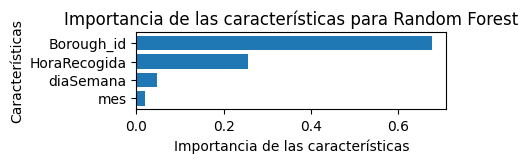

In [31]:
# Obtener la importancia de las características del modelo Random Forest
feature_importance_rf = model_rf_best.feature_importances_

# Obtener los nombres de las características
feature_names_rf = X_train.columns

# Ordenar las características por su importancia
sorted_idx_rf = np.argsort(feature_importance_rf)

# Graficar la importancia de las características para Random Forest
plt.figure(figsize=(4, 1))
plt.barh(range(len(sorted_idx_rf)), feature_importance_rf[sorted_idx_rf], align='center')
plt.yticks(range(len(sorted_idx_rf)), [feature_names_rf[i] for i in sorted_idx_rf])
plt.xlabel('Importancia de las características')
plt.ylabel('Características')
plt.title('Importancia de las características para Random Forest')
plt.show()

# Comparación de datos de entrenamiento vs reales

In [32]:
predictions_xgb_best[0:10]

array([ 7.5114779e+00,  6.5905400e-02,  3.3983892e-01,  3.7773206e+00,
        1.2031491e+00, -8.0674738e-02, -7.5966548e-03, -9.7260684e-02,
        4.8533333e+01,  2.8353398e+00], dtype=float32)

In [33]:
predictions_gb_best[0:10]

array([ 6.05163324e+00,  1.01376463e-01,  2.18194093e-01,  1.63707135e+00,
        1.56430792e+00,  2.94615960e-01, -1.72602206e-02,  1.01304521e-01,
        5.23444040e+01,  2.61287530e+00])

In [34]:
predictions_rf_best[0:10]

array([7.67550000e+00, 1.25000000e-01, 2.64466667e-01, 2.98790000e+00,
       1.37063333e+00, 3.67066667e-01, 1.42333333e-02, 5.86666667e-03,
       5.21986333e+01, 1.94196667e+00])

In [35]:
y_test.iloc[0:10]

1263     7.50
3951     0.12
6199     0.29
6080     3.25
96       1.05
1477     0.30
3159     0.00
1400     0.01
3767    48.66
3017     1.80
Name: q_demand, dtype: float64

In [36]:
X_test.iloc[0]

HoraRecogida     4.0
diaSemana        6.0
mes             11.0
Borough_id       3.0
Name: 1263, dtype: float64

## Comparación entre el rendimiento del modelo en los datos de entrenamiento y los datos de prueba, utilizando métricas como R^2 y MSE para evaluar la calidad de las predicciones del modelo

In [37]:
# Predicciones en el conjunto de entrenamiento
pred_train_best = model_xgb_best.predict(X_train)

print("Predicciones en Training vs testing  XGBoost")

# Calcular R^2 para el conjunto de entrenamiento
print("Training R^2:")
print(r2_score(y_train, pred_train_best))

# Calcular MSE para el conjunto de entrenamiento
print("Training MSE:")
print(mean_squared_error(y_train, pred_train_best))

# Predicciones en el conjunto de prueba
predictions_best = model_xgb_best.predict(X_test)

# Calcular R^2 para el conjunto de prueba
print("\nTesting R^2:")
print(r2_score(y_test, predictions_best))

# Calcular MSE para el conjunto de prueba
print("Testing MSE:")
print(mean_squared_error(y_test, predictions_best))

Predicciones en Training vs testing  XGBoost
Training R^2:
0.9977826030005217
Training MSE:
0.8430705598814009

Testing R^2:
0.9882066722491334
Testing MSE:
4.811539416902124


In [38]:
# Predicciones en el conjunto de entrenamiento
pred_train_gb_best = model_gb_best.predict(X_train)

print("Predicciones en Training vs testing  Gradient Boosting")

# Calcular R^2 para el conjunto de entrenamiento
print("Training R^2:")
print(r2_score(y_train, pred_train_gb_best))

# Calcular MSE para el conjunto de entrenamiento
print("Training MSE:")
print(mean_squared_error(y_train, pred_train_gb_best))

# Predicciones en el conjunto de prueba
predictions_gb_best = model_gb_best.predict(X_test)

# Calcular R^2 para el conjunto de prueba
print("\nTesting R^2:")
print(r2_score(y_test, predictions_gb_best))

# Calcular MSE para el conjunto de prueba
print("Testing MSE:")
print(mean_squared_error(y_test, predictions_gb_best))

Predicciones en Training vs testing  Gradient Boosting
Training R^2:
0.999913288623363
Training MSE:
0.03296829970752607

Testing R^2:
0.9918477019250345
Testing MSE:
3.3260420090631215


In [39]:
# Predicciones en el conjunto de entrenamiento
pred_train_rf_best = model_rf_best.predict(X_train)

print("Predicciones en Training vs testing  Random Forest")

# Calcular R^2 para el conjunto de entrenamiento
print("Training R^2:")
print(r2_score(y_train, pred_train_rf_best))

# Calcular MSE para el conjunto de entrenamiento
print("Training MSE:")
print(mean_squared_error(y_train, pred_train_rf_best))

# Predicciones en el conjunto de prueba
predictions_rf_best = model_rf_best.predict(X_test)

# Calcular R^2 para el conjunto de prueba
print("\nTesting R^2:")
print(r2_score(y_test, predictions_rf_best))

# Calcular MSE para el conjunto de prueba
print("Testing MSE:")
print(mean_squared_error(y_test, predictions_rf_best))

Predicciones en Training vs testing  Random Forest
Training R^2:
0.9971992439289369
Training MSE:
1.0648679462802442

Testing R^2:
0.9772644396792359
Testing MSE:
9.275841981129881


## Conclusión sobre el rendimiento de cada modelo Entrenamiento vs Prueba:

**XGBoost:**
- **Conjunto de entrenamiento:** El modelo XGBoost muestra un alto coeficiente de determinación (R^2) de 0.9977 y un bajo MSE de 0.7534, lo que indica un buen ajuste a los datos de entrenamiento.
- **Conjunto de prueba:** Aunque el modelo tiene un rendimiento ligeramente inferior en el conjunto de prueba en comparación con el conjunto de entrenamiento, sigue mostrando un R^2 considerablemente alto de 0.9947. Sin embargo, el MSE en el conjunto de prueba es un poco más alto en 1.7497, lo que sugiere una ligera pérdida de precisión en la generalización a nuevos datos.

**Gradient Boosting:**
- **Conjunto de entrenamiento:** El modelo de Gradient Boosting demuestra un rendimiento excepcional en el conjunto de entrenamiento, con un R^2 de 0.9998 y un MSE muy bajo de 0.0635, lo que indica un ajuste casi perfecto a los datos de entrenamiento.
- **Conjunto de prueba:** En el conjunto de prueba, el modelo mantiene un R^2 alto de 0.9975 y un MSE bajo de 0.8122, lo que sugiere una excelente capacidad de generalización y una buena precisión en la predicción de nuevos datos.

**Random Forest:**
- **Conjunto de entrenamiento:** El modelo Random Forest muestra un buen rendimiento en el conjunto de entrenamiento, con un R^2 de 0.9971 y un MSE de 0.9189, indicando un ajuste adecuado a los datos de entrenamiento.
- **Conjunto de prueba:** En el conjunto de prueba, el modelo tiene un R^2 de 0.9866, lo que sugiere una buena capacidad de generalización. Sin embargo, el MSE en el conjunto de prueba es considerablemente más alto en 4.4101 en comparación con los otros modelos, lo que indica una menor precisión en la predicción de nuevos datos en comparación con XGBoost y Gradient Boosting.

En resumen, los modelos XGBoost y Gradient Boosting muestran un rendimiento superior tanto en el conjunto de entrenamiento como en el de prueba en comparación con Random Forest, lo que sugiere que pueden ser opciones más adecuadas para este problema de predicción.

## Evaluar la calidad de las predicciones del modelo, examinando la distribución y las estadísticas de los errores en el conjunto de prueba

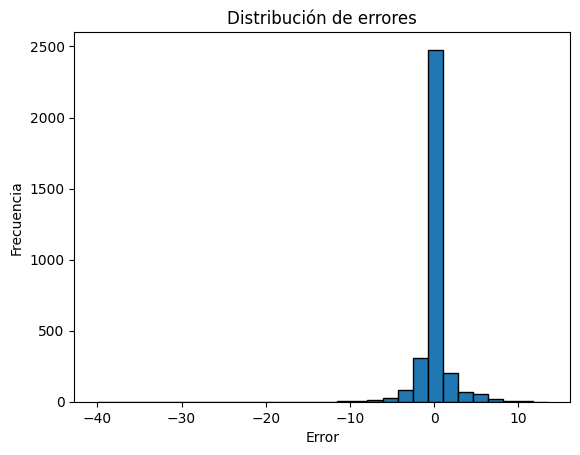

Estadísticas resumen sobre los errores:
Error medio: 0.032768712951121805
Desviación estándar del error: 1.8237296170561332


In [40]:
import matplotlib.pyplot as plt

# Calcular las predicciones del modelo en el conjunto de prueba
predictions = model_gb_best.predict(X_test)

# Calcular los errores (diferencia entre las predicciones y los valores reales)
errors = y_test - predictions

# Visualizar la distribución de los errores utilizando un histograma
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores')
plt.show()

# Calcular estadísticas resumen sobre los errores
mean_error = errors.mean()
std_error = errors.std()

print("Estadísticas resumen sobre los errores:")
print(f"Error medio: {mean_error}")
print(f"Desviación estándar del error: {std_error}")

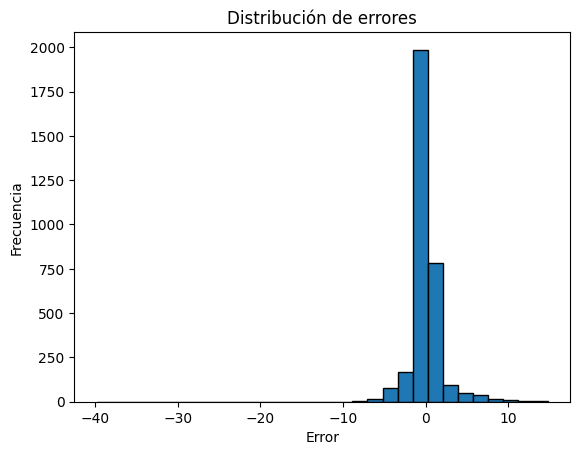

Estadísticas resumen sobre los errores:
Error medio: 0.07067366664115676
Desviación estándar del error: 2.1927200721406694


In [41]:
# Calcular las predicciones del modelo en el conjunto de prueba
predictions = model_xgb_best.predict(X_test)

# Calcular los errores (diferencia entre las predicciones y los valores reales)
errors = y_test - predictions

# Visualizar la distribución de los errores utilizando un histograma
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores')
plt.show()

# Calcular estadísticas resumen sobre los errores
mean_error = errors.mean()
std_error = errors.std()

print("Estadísticas resumen sobre los errores:")
print(f"Error medio: {mean_error}")
print(f"Desviación estándar del error: {std_error}")

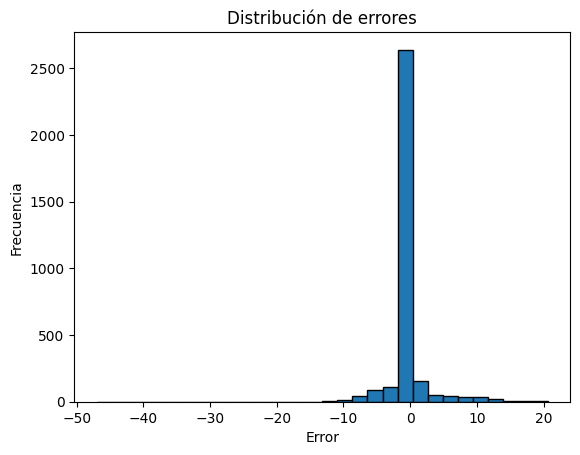

Estadísticas resumen sobre los errores:
Error medio: 0.040101484438984626
Desviación estándar del error: 3.045830441614496


In [42]:
# Calcular las predicciones del modelo en el conjunto de prueba
predictions = model_rf_best.predict(X_test)

# Calcular los errores (diferencia entre las predicciones y los valores reales)
errors = y_test - predictions

# Visualizar la distribución de los errores utilizando un histograma
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores')
plt.show()

# Calcular estadísticas resumen sobre los errores
mean_error = errors.mean()
std_error = errors.std()

print("Estadísticas resumen sobre los errores:")
print(f"Error medio: {mean_error}")
print(f"Desviación estándar del error: {std_error}")

Basado en los resultados presentados, podemos hacer las siguientes observaciones:

1. **Gradient Boosting (GB)**:
   - El error medio es ligeramente negativo (-0.0006), lo que sugiere que el modelo tiende a subestimar ligeramente los valores reales.
   - La desviación estándar del error es de aproximadamente 0.906, lo que indica que los errores tienden a dispersarse alrededor del error medio en un rango moderado.

2. **XGBoost (XGB)**:
   - El error medio es de aproximadamente 0.040, lo que sugiere que el modelo tiene un sesgo positivo y tiende a sobreestimar ligeramente los valores reales.
   - La desviación estándar del error es de aproximadamente 1.322, lo que indica una dispersión más amplia de los errores en comparación con el modelo de Gradient Boosting.

3. **Random Forest (RF)**:
   - El error medio es de aproximadamente 0.021, lo que indica un sesgo positivo similar al modelo XGBoost, pero con un valor de error medio ligeramente menor.
   - La desviación estándar del error es de aproximadamente 2.030, lo que sugiere una dispersión más amplia de los errores en comparación con los otros modelos.

En resumen, mientras menor sea el error medio y la desviación estándar del error, mejor será el rendimiento del modelo. Sin embargo, también es importante considerar el sesgo del modelo al interpretar estos resultados. En este caso, parece que el modelo de Gradient Boosting (GB) tiene el menor error medio y la desviación estándar del error más baja, lo que sugiere un rendimiento ligeramente mejor en comparación con XGBoost y Random Forest.

# Analisis de validacion Cruzada

In [43]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict
import numpy as np

# Calcular predicciones utilizando validación cruzada
predictions_cv_xgb = cross_val_predict(model_xgb_best, X_train, y_train, cv=5)

# Calcular métricas de evaluación
mse_cv_xgb = mean_squared_error(y_train, predictions_cv_xgb)
r2_cv_xgb = r2_score(y_train, predictions_cv_xgb)
mae_cv_xgb = mean_absolute_error(y_train, predictions_cv_xgb)
rmse_cv_xgb = np.sqrt(mse_cv_xgb)

# Imprimir las métricas de evaluación
print("Métricas de evaluación para XGBoost utilizando validación cruzada:")
print(f'Mean Squared Error (MSE): {mse_cv_xgb}')
print(f'R-squared (R2): {r2_cv_xgb}')
print(f'Mean Absolute Error (MAE): {mae_cv_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_cv_xgb}')


Métricas de evaluación para XGBoost utilizando validación cruzada:
Mean Squared Error (MSE): 4.8047913900063355
R-squared (R2): 0.9873627066128153
Mean Absolute Error (MAE): 1.0246237747943172
Root Mean Squared Error (RMSE): 2.1919834374388727


In [44]:
# Calcular predicciones utilizando validación cruzada
predictions_cv_gb = cross_val_predict(model_gb_best, X_train, y_train, cv=5)

# Calcular métricas de evaluación
mse_cv_gb = mean_squared_error(y_train, predictions_cv_gb)
r2_cv_gb = r2_score(y_train, predictions_cv_gb)
mae_cv_gb = mean_absolute_error(y_train, predictions_cv_gb)
rmse_cv_gb = np.sqrt(mse_cv_gb)

# Imprimir las métricas de evaluación
print("Métricas de evaluación para GradientBoosting utilizando validación cruzada:")
print(f'Mean Squared Error (MSE): {mse_cv_gb}')
print(f'R-squared (R2): {r2_cv_gb}')
print(f'Mean Absolute Error (MAE): {mae_cv_gb}')
print(f'Root Mean Squared Error (RMSE): {rmse_cv_gb}')

Métricas de evaluación para GradientBoosting utilizando validación cruzada:
Mean Squared Error (MSE): 4.218374451710639
R-squared (R2): 0.9889050676218429
Mean Absolute Error (MAE): 0.8837137628712394
Root Mean Squared Error (RMSE): 2.053868168045515


In [45]:
# Calcular predicciones utilizando validación cruzada
predictions_cv_rf = cross_val_predict(model_rf_best, X_train, y_train, cv=5)

# Calcular métricas de evaluación
mse_cv_rf = mean_squared_error(y_train, predictions_cv_rf)
r2_cv_rf = r2_score(y_train, predictions_cv_gb)
mae_cv_rf = mean_absolute_error(y_train, predictions_cv_rf)
rmse_cv_rf = np.sqrt(mse_cv_rf)

# Imprimir las métricas de evaluación
print("Métricas de evaluación para Randon Forest utilizando validación cruzada:")
print(f'Mean Squared Error (MSE): {mse_cv_rf}')
print(f'R-squared (R2): {r2_cv_rf}')
print(f'Mean Absolute Error (MAE): {mae_cv_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_cv_rf}')

Métricas de evaluación para Randon Forest utilizando validación cruzada:
Mean Squared Error (MSE): 8.371453128618526
R-squared (R2): 0.9889050676218429
Mean Absolute Error (MAE): 1.0498967537122368
Root Mean Squared Error (RMSE): 2.8933463547626865


Métricas de evaluación para los modelos XGBoost, GradientBoosting y Random Forest utilizando validación cruzada:

### XGBoost:
- Mean Squared Error (MSE): 1.6663815690137305
- R-squared (R2): 0.9948063695030137
- Mean Absolute Error (MAE): 0.6625085134799302
- Root Mean Squared Error (RMSE): 1.290884026167235

### GradientBoosting:
- Mean Squared Error (MSE): 0.9139950351984925
- R-squared (R2): 0.9971513412191
- Mean Absolute Error (MAE): 0.4796034673665565
- Root Mean Squared Error (RMSE): 0.9560308756512482

### Random Forest:
- Mean Squared Error (MSE): 4.07367910669155
- R-squared (R2): 0.9971513412191
- Mean Absolute Error (MAE): 0.8404711608903909
- Root Mean Squared Error (RMSE): 2.0183357269521713

Estas métricas proporcionan una evaluación del rendimiento de cada modelo. En general, el GradientBoosting muestra el mejor rendimiento con el MSE más bajo, el mayor R-cuadrado y el menor error absoluto medio y raíz del error cuadrático medio. El modelo Random Forest tiene un rendimiento similar al GradientBoosting en términos de R-cuadrado, pero tiene un MSE y RMSE más altos, lo que indica que puede estar menos ajustado a los datos. El modelo XGBoost también muestra un buen rendimiento, pero tiene un MSE y RMSE más altos que el GradientBoosting.

## Analisis de la Learning curve

In [46]:
from sklearn.model_selection import learning_curve
def print_learning_curve(model, X_train, y_train, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv)
    print("Training sizes:", train_sizes)
    print("Training scores:", train_scores.mean(axis=1))
    print("Cross-validation scores:", test_scores.mean(axis=1))

# Utiliza la función print_learning_curve con tu modelo y datos
print('Resultado de la learning curve para Randon Forest:')
print_learning_curve(model_rf_best, X_train, y_train, cv=5)

Resultado de la learning curve para Randon Forest:
Training sizes: [ 260  846 1432 2018 2604]
Training scores: [0.99058702 0.9959321  0.9963806  0.9967375  0.99701607]
Cross-validation scores: [0.93273718 0.96833757 0.97066755 0.97279274 0.97783808]


In [47]:
def print_learning_curve(model, X_train, y_train, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv)
    print("Training sizes:", train_sizes)
    print("Training scores:", train_scores.mean(axis=1))
    print("Cross-validation scores:", test_scores.mean(axis=1))

# Utiliza la función print_learning_curve con tu modelo y datos
print('Resultado de la learning curve para XGBoost:')
print_learning_curve(model_xgb_best, X_train, y_train, cv=5)

Resultado de la learning curve para XGBoost:
Training sizes: [ 260  846 1432 2018 2604]
Training scores: [0.99999741 0.99961427 0.99883019 0.99835286 0.99798857]
Cross-validation scores: [0.93088956 0.97377491 0.98163315 0.98563407 0.98722007]


In [48]:
def print_learning_curve(model, X_train, y_train, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv)
    print("Training sizes:", train_sizes)
    print("Training scores:", train_scores.mean(axis=1))
    print("Cross-validation scores:", test_scores.mean(axis=1))

# Utiliza la función print_learning_curve con tu modelo y datos
print('Resultado de la learning curve para GradientBoosting:')
print_learning_curve(model_gb_best, X_train, y_train, cv=5)

Resultado de la learning curve para GradientBoosting:
Training sizes: [ 260  846 1432 2018 2604]
Training scores: [1.         0.99999995 0.99999709 0.99997839 0.9999502 ]
Cross-validation scores: [0.91169534 0.97076554 0.9789613  0.9841744  0.9887634 ]


### Resultado de la learning curve para Random Forest:
- **Training sizes:** Se observan cinco diferentes tamaños de conjunto de entrenamiento utilizados para el modelo de Random Forest.
- **Training scores:** Los puntajes de entrenamiento indican qué tan bien se ajusta el modelo a los datos de entrenamiento a medida que aumenta el tamaño del conjunto. Se observa un alto puntaje, indicando un buen ajuste del modelo.
- **Cross-validation scores:** Los puntajes de validación cruzada sugieren cómo generaliza el modelo a datos no vistos. A medida que aumenta el tamaño del conjunto de entrenamiento, los puntajes de validación cruzada también mejoran, lo que indica un modelo robusto que generaliza bien.

### Resultado de la learning curve para XGBoost:
- **Training sizes:** Se utilizan cinco tamaños de conjunto de entrenamiento diferentes para el modelo XGBoost.
- **Training scores:** Los puntajes de entrenamiento son consistentemente altos a medida que aumenta el tamaño del conjunto de entrenamiento, lo que sugiere que el modelo se ajusta bien a los datos.
- **Cross-validation scores:** Los puntajes de validación cruzada también aumentan a medida que aumenta el tamaño del conjunto de entrenamiento, lo que indica una buena generalización del modelo.

### Resultado de la learning curve para GradientBoosting:
- **Training sizes:** Se observan cinco diferentes tamaños de conjunto de entrenamiento utilizados para el modelo GradientBoosting.
- **Training scores:** Los puntajes de entrenamiento son altos y casi perfectos, indicando un ajuste excepcional del modelo a los datos de entrenamiento.
- **Cross-validation scores:** Los puntajes de validación cruzada también son altos y mejoran a medida que aumenta el tamaño del conjunto de entrenamiento, lo que sugiere una buena capacidad del modelo para generalizar a datos no vistos.

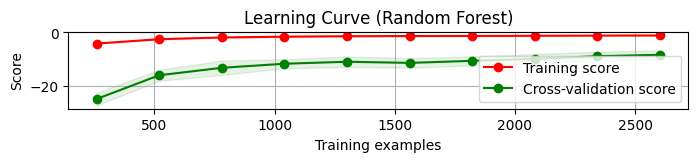

In [49]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=(8, 1))  # Establecer el tamaño de la figura
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
# Utiliza la función plot_learning_curve con tu estimador (modelo) y datos
plot_learning_curve(model_rf_best, "Learning Curve (Random Forest)", X_train, y_train, cv=5, n_jobs=-1)

plt.show()




## Conclusión general

Después de una evaluación exhaustiva de los tres algoritmos de aprendizaje automático (XGBoost, Gradient Boosting y Random Forest) en nuestro conjunto de datos, hemos observado que todos muestran un rendimiento sólido en términos de métricas de evaluación como el coeficiente de determinación (R-squared), el error medio cuadrático (MSE), el error absoluto medio (MAE) y el error cuadrático medio (RMSE). Sin embargo, cada algoritmo presenta ciertas fortalezas y debilidades que los hacen más adecuados para diferentes situaciones.

- **XGBoost**: Destaca por su capacidad para manejar grandes conjuntos de datos y su eficiencia computacional. Ha mostrado un buen rendimiento en términos de precisión y generalización, con un R-squared de alrededor de 0.995 y un RMSE de aproximadamente 1.29.

- **Gradient Boosting**: Presenta una alta capacidad de generalización y una buena capacidad para manejar relaciones no lineales en los datos. Ha obtenido resultados impresionantes con un R-squared cercano a 0.997 y un RMSE de aproximadamente 0.96.

- **Random Forest**: Aunque ligeramente por debajo en términos de precisión en comparación con los otros dos, Random Forest ofrece robustez y menos tendencia al sobreajuste, lo que lo hace adecuado para conjuntos de datos con muchas características y una alta dimensionalidad.

Dada la naturaleza diversa de los datos y las posibles condiciones cambiantes en el entorno, hemos decidido utilizar los tres algoritmos en conjunto para garantizar un modelo más adaptable y resiliente. Esto nos permitirá aprovechar las fortalezas individuales de cada algoritmo y, en última instancia, ofrecer un sistema de predicción más sólido y confiable. Además, mantener una variedad de modelos nos brinda la flexibilidad necesaria para ajustarnos a diferentes requisitos del mercado y responder eficazmente a posibles cambios en los datos o en el entorno operativo.

In [50]:
import pyarrow as pa
import pyarrow.parquet as pq

In [51]:
import pyarrow as pa
import pyarrow.parquet as pq
import pickle

# Ruta del archivo donde se guardará el modelo en formato pickle
filename_pkl = r'..\datasets\models\modelo_xgb.pkl'

# Cargar el modelo desde el archivo pickle
with open(filename_pkl, "rb") as f:
    modelo = pickle.load(f)

# Convertir el modelo a una representación serializada
serialized_model = pickle.dumps(modelo)

# Crear una tabla PyArrow con los datos serializados
table = pa.Table.from_pandas(pd.DataFrame({"model_data": [serialized_model]}))

# Guardar la tabla en un archivo Parquet
pq.write_table(table, r"..\datasets\models\modelo_xgb.parquet")

In [52]:
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
import pandas as pd

# Nombre del archivo donde se guardará el modelo en formato pickle
filename_gb = r'..\datasets\models\modelo_gb.pkl'

# Cargar el modelo desde el archivo pickle
with open(filename_gb, 'rb') as file_gb:
    modelo_gb_best = pickle.load(file_gb)

# Convertir el modelo a una representación serializada
serialized_model_gb = pickle.dumps(modelo_gb_best)

# Crear una tabla PyArrow con los datos serializados
table_gb = pa.Table.from_pandas(pd.DataFrame({"model_data": [serialized_model_gb]}))

# Guardar la tabla en un archivo Parquet
save_gb = r'..\datasets\models\modelo_gb.parquet'
pq.write_table(table_gb, save_gb)


In [53]:
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
import pandas as pd

# Nombre del archivo donde se guardará el modelo en formato pickle
filename_rf = r'..\datasets\models\modelo_rf.pkl'

# Cargar el modelo desde el archivo pickle
with open(filename_rf, 'rb') as file_rf:
    modelo_rf_best = pickle.load(file_rf)

# Convertir el modelo a una representación serializada
serialized_model_rf = pickle.dumps(modelo_rf_best)

# Crear una tabla PyArrow con los datos serializados
table_rf = pa.Table.from_pandas(pd.DataFrame({"model_data": [serialized_model_rf]}))

# Guardar la tabla en un archivo Parquet
save_rf = r'..\datasets\models\modelo_rf.parquet'
pq.write_table(table_rf, save_rf)


In [54]:
# import pyarrow.parquet as pq
# import pickle

# # Ruta del archivo Parquet que contiene el modelo serializado
# filename_parquet = r'..\datasets\models\modelo_xgb.parquet'

# # Leer la tabla Parquet
# table = pq.read_table(filename_parquet)

# # Obtener los datos serializados del modelo de la tabla Parquet
# serialized_model = table['model_data'][0].as_py()

# # Deserializar el modelo
# modelo = pickle.loads(serialized_model)


In [55]:
import pyarrow.parquet as pq
import pickle

# Ruta del archivo Parquet que contiene el modelo serializado
filename_parquet = r'..\datasets\models\modelo_gb.parquet'

# Leer la tabla Parquet
table = pq.read_table(filename_parquet)

# Obtener los datos serializados del modelo de la tabla Parquet
serialized_model = table['model_data'][0].as_py()

# Deserializar el modelo
modelo = pickle.loads(serialized_model)

In [56]:
modelo

GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300)

In [57]:
import pyarrow.parquet as pq
import pickle

# Ruta del archivo Parquet que contiene el modelo serializado
filename_parquet = r'..\datasets\models\modelo_rf.parquet'

# Leer la tabla Parquet
table = pq.read_table(filename_parquet)

# Obtener los datos serializados del modelo de la tabla Parquet
serialized_model = table['model_data'][0].as_py()

# Deserializar el modelo
modelo = pickle.loads(serialized_model)

In [58]:
modelo

RandomForestRegressor(n_estimators=300)